In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [ ]:
customers_path = '/content/Customers.csv'
transactions_path = '/content/Transactions.csv'

In [ ]:
customers_df = pd.read_csv(customers_path)
transactions_df = pd.read_csv(transactions_path)

In [ ]:
customers_df['SignupDate'] = pd.to_datetime(customers_df['SignupDate'])
transactions_df['TransactionDate'] = pd.to_datetime(transactions_df['TransactionDate'])

In [ ]:
customer_transactions = transactions_df.groupby('CustomerID').agg(
    total_spend=('TotalValue', 'sum'),
    transaction_count=('TransactionID', 'count'),
    avg_transaction_value=('TotalValue', 'mean'),
    avg_price=('Price', 'mean')
).reset_index()

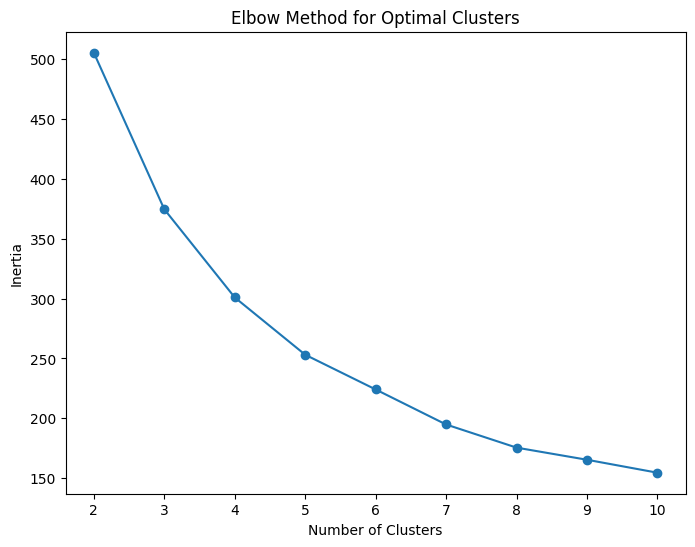

In [ ]:
customer_profile = pd.merge(customers_df, customer_transactions, on='CustomerID', how='left')

customer_profile.fillna({'total_spend': 0, 'transaction_count': 0, 'avg_transaction_value': 0, 'avg_price': 0}, inplace=True)

features = ['total_spend', 'transaction_count', 'avg_transaction_value', 'avg_price']
X = customer_profile[features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

inertia = []
range_clusters = range(2, 11)

for k in range_clusters:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 6))
plt.plot(range_clusters, inertia, marker='o')
plt.title('Elbow Method for Optimal Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

In [ ]:
optimal_clusters = 4
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
customer_profile['Cluster'] = kmeans.fit_predict(X_scaled)

db_index = davies_bouldin_score(X_scaled, customer_profile['Cluster'])
silhouette_avg = silhouette_score(X_scaled, customer_profile['Cluster'])

print(f"Optimal Clusters: {optimal_clusters}")
print(f"Davies-Bouldin Index: {db_index:.4f}")
print(f"Silhouette Score: {silhouette_avg:.4f}")



Optimal Clusters: 4
Davies-Bouldin Index: 0.9675
Silhouette Score: 0.3166


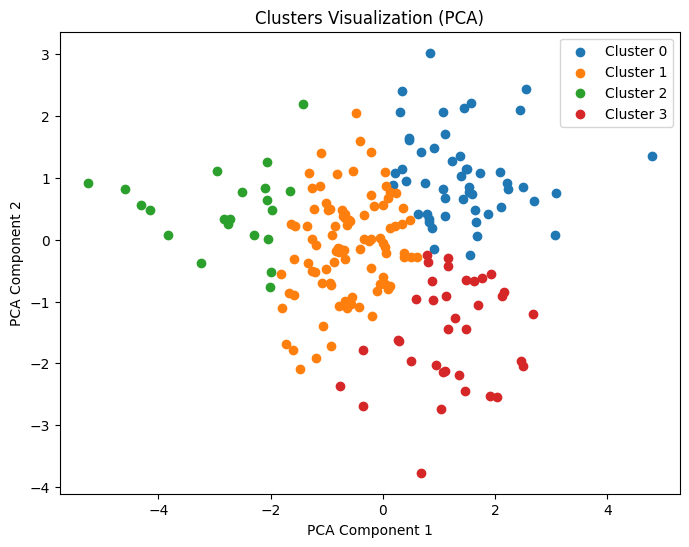

In [ ]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
for cluster in range(optimal_clusters):
    plt.scatter(X_pca[customer_profile['Cluster'] == cluster, 0],
                X_pca[customer_profile['Cluster'] == cluster, 1],
                label=f'Cluster {cluster}')
plt.title('Clusters Visualization (PCA)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.show()

customer_profile.to_csv('Clustered_Customers.csv', index=False)

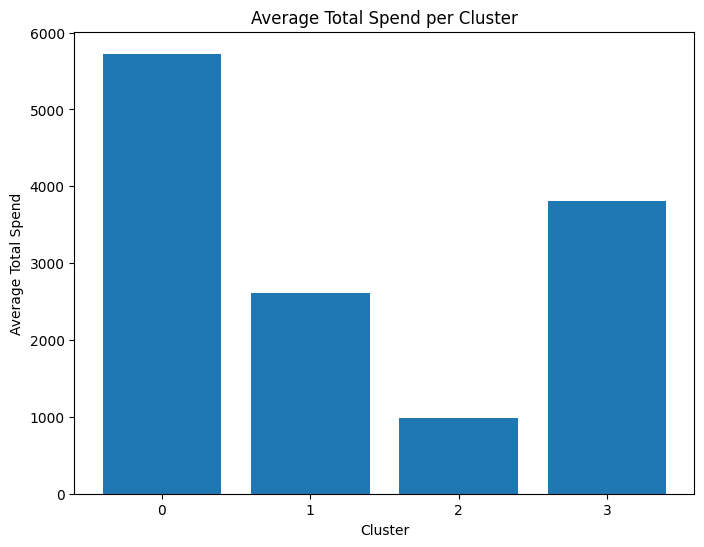

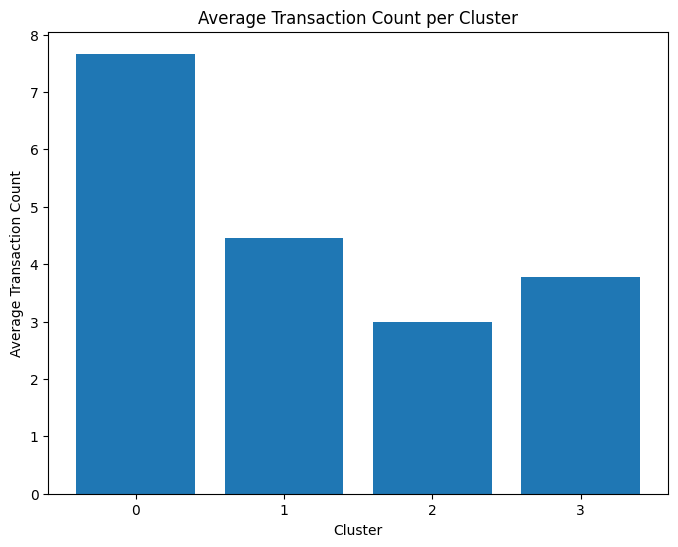

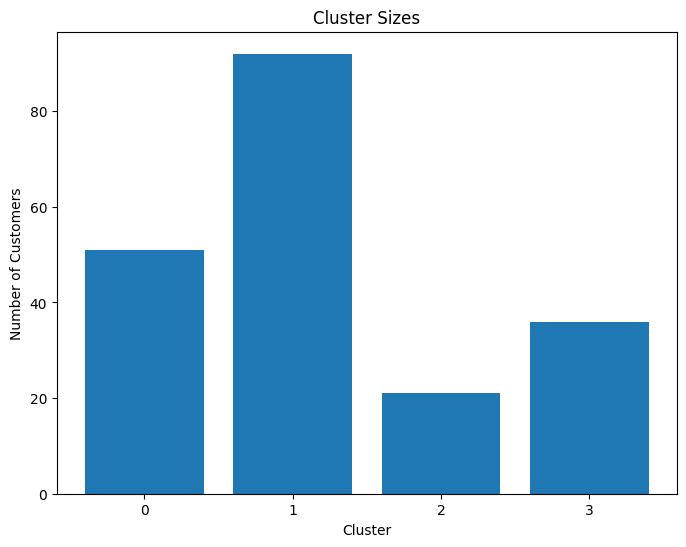

In [ ]:
clustered_data = pd.read_csv("/content/Clustered_Customers.csv")

cluster_summary = clustered_data.groupby('Cluster').agg(
    avg_total_spend=('total_spend', 'mean'),
    avg_transaction_count=('transaction_count', 'mean'),
    avg_transaction_value=('avg_transaction_value', 'mean'),
    avg_price=('avg_price', 'mean'),
    cluster_size=('Cluster', 'count')
).reset_index()

plt.figure(figsize=(8, 6))
plt.bar(cluster_summary['Cluster'], cluster_summary['avg_total_spend'], tick_label=cluster_summary['Cluster'])
plt.title('Average Total Spend per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Average Total Spend')
plt.show()

plt.figure(figsize=(8, 6))
plt.bar(cluster_summary['Cluster'], cluster_summary['avg_transaction_count'], tick_label=cluster_summary['Cluster'])
plt.title('Average Transaction Count per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Average Transaction Count')
plt.show()

plt.figure(figsize=(8, 6))
plt.bar(cluster_summary['Cluster'], cluster_summary['cluster_size'], tick_label=cluster_summary['Cluster'])
plt.title('Cluster Sizes')
plt.xlabel('Cluster')
plt.ylabel('Number of Customers')
plt.show()
